# Project : SVM & Logistic Regression for Wine-Quality Prediction 

project led by : Corentin LAGADEC

referent teachers:  Nicolò Cesa-Bianchi

# 0) Introduction

The goal of this project is to implement two classic binary classification algorithms — **Logistic Regression** and **Support Vector Machine (SVM)** — entirely from scratch, without relying on machine learning libraries such as scikit-learn.

We will work with the Wine Quality dataset from the UCI Machine Learning Repository, which contains physicochemical attributes of both red and white wines, along with quality scores assigned by wine experts.

The task is to predict whether a wine is "good" (quality ≥ 6) or "bad" (quality < 6), combining red and white wines in a single binary classification problem.

This project includes the following key steps:

   - Exploratory Data Analysis and preprocessing

   - From-scratch implementation of Logistic Regression and SVM, including kernelized versions

   - Model training with appropriate hyperparameter tuning

   - Performance evaluation using metrics such as accuracy, precision, recall, and F1-score

   - Error analysis and discussion of possible underfitting or overfitting

All work is conducted in Python using basic libraries such as numpy, pandas, matplotlib, and seaborn for numerical operations, data manipulation, and visualization.

This project aims to strengthen understanding of the algorithmic foundations of machine learning, and to encourage sound practices in model development, evaluation, and interpretation.


In [4]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import time
import math

# 1) Partie 1 : Data Exploration & Preprocessing

  **Goals :**

   - Analyse the data (exploration)

   - Create the binary target: ‘good’ (quality ≥ 6) or ‘bad’ (quality < 6)
   
   - Prepare data for training (train/test split, normalisation )

    

# 1.1) Loading data

In [5]:
# Loading the 2 data sets
red_wine = pd.read_csv("winequality-red.csv", sep=";")
white_wine = pd.read_csv("winequality-white.csv", sep=";")

# Add a “type” column to find out where the wine comes from
# red wine will be denoted by 0
red_wine['type'] = 0
# white wine will be denoted by 1
white_wine['type'] = 1

# Merging the 2 data sets
wine = pd.concat([red_wine, white_wine], ignore_index=True)
df = wine.copy()

# 1.2) Data set exploration

In [6]:
# printing the first 5 rows of dataset
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [7]:
# describe the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


To sum up : 
- 0 : fixed acidity

- 1 : volatile acidity

- 2 : citric acid

- 3 : residual sugar

- 4 : chlorides

- 5 : free sulfur dioxide

- 6 : total sulfur dioxide

- 7 : density

- 8 : pH

- 9 : sulphates

- 10 : alcohol

- 12 : type (type of wine red or white)

Output variable (based on sensory data): 

- 11 : quality (score between 0 and 10)

In [8]:
#describe statistic for each features
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


In [9]:
df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [10]:
# looking for missing values
print(df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


No missing values, that's great

# 1.3) Creating the binary target

In [11]:
# Creating the binary target
df['label'] = np.where(df['quality'] >= 6, 1, -1)

In [12]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,-1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,-1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,-1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,-1


In [13]:
# Categorical variables
categorical_features = ['type']

# Numericals variables
numerical_features = [col for col in df.columns if col not in categorical_features + ['label'] + ['quality']]

# 1.4) Exploratory analysis (EDA)

In [14]:
def draw_pie(df):
    labels_counts = df['label'].value_counts().sort_index() 
    print(labels_counts)
    # Plot to see the percentage distribution of labels

    labels = ['Bad quality (< 6) (-1)', 'Good quality (>= 6) (1)']

    # plot of the pie
    plt.figure(figsize=(7,7))
    plt.pie(labels_counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Bad vs Good quality')
    plt.axis('equal')  # Assure un cercle parfait
    plt.show()

label
-1    2384
 1    4113
Name: count, dtype: int64


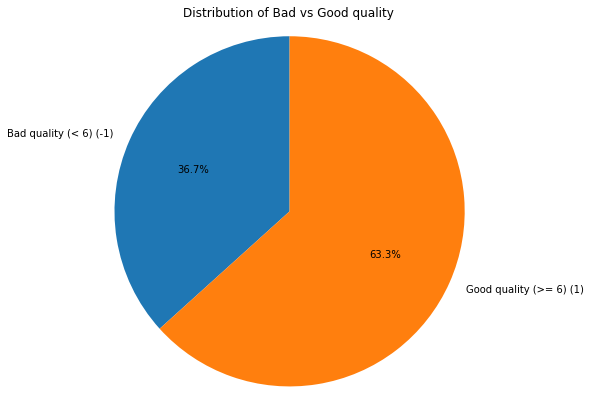

In [15]:
draw_pie(df)

We can see that the data set is not perfectly balanced between good and poor quality wines. But this is not extreme, I will first going to try our 2 algorithms without applying a data resampling method.

# 1.4.1) Exploring correlations

In [16]:
def heat_map(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(20, 15))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()


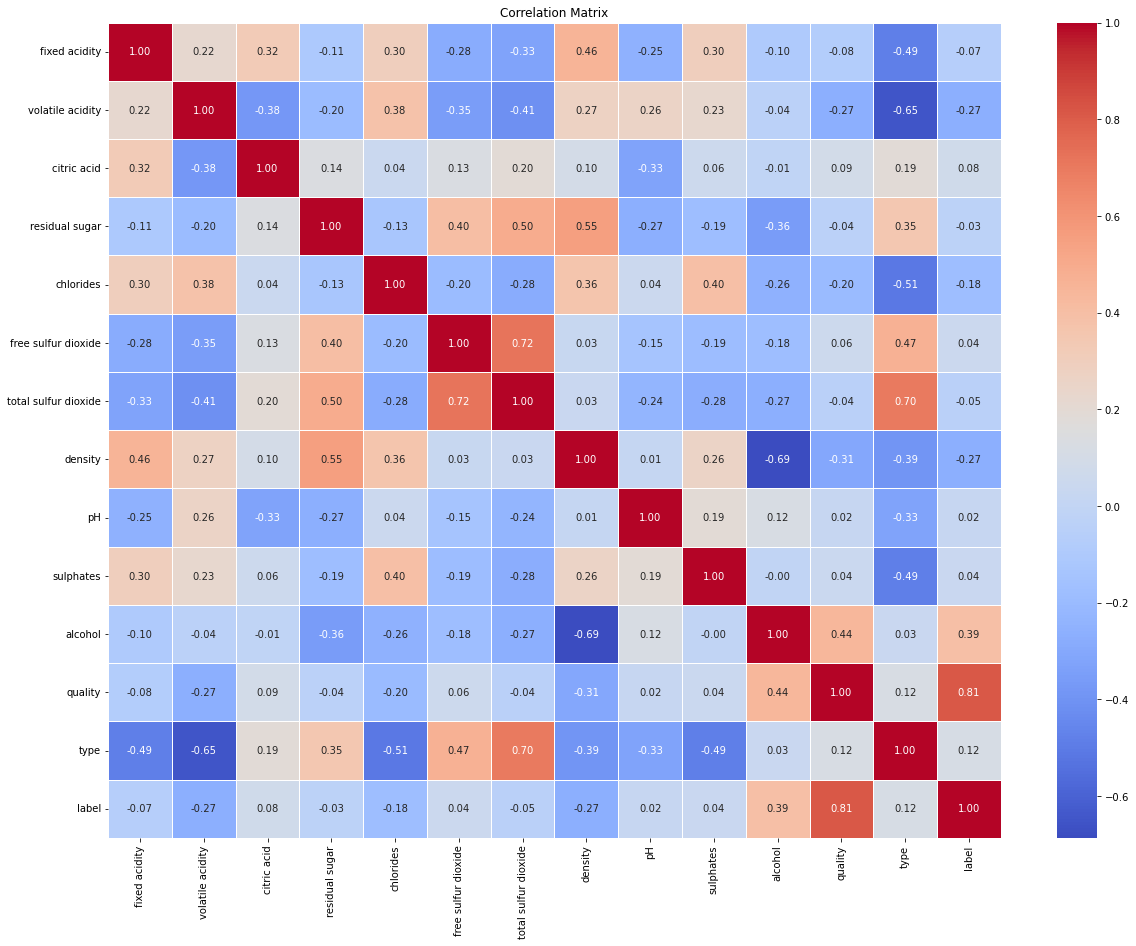

In [17]:
heat_map(df)

We can see that the variable wine "type” is strongly correlated to the "total sulfur dioxide" variable (0,70). And that "total sulfur dioxide" and "free sulfur dioxide" are also strongly correlated (0,72). The target variable "label" does not seem to be explained by a single variable, "alcohol" stands out a little (0,39).

**Remark :** Obiously the quality target is strongly correlated to label target, I will drop the quality columns in the next part.

# 1.4.2) Numerical variables

In [18]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=[15, 8], constrained_layout=True)
    if n_rows * n_cols == 1:
        axes = [axes]  # liste avec un seul élément
    else:
        axes = axes.flatten()
    #axes = axes.flatten()
    
    for i, col in enumerate(variables):
        if i >= len(axes):
            break  
        plt.sca(axes[i])
        df[col].hist(bins=n_bins)
        plt.title(col)
        
        mean_val = df[col].mean()
        median_val = df[col].median()
        plt.axvline(mean_val, color='orange', linestyle='--', linewidth=1.5, label='Mean')
        plt.axvline(median_val, color='green', linestyle='--', linewidth=1.5, label='Median')

        plt.title(col)
        plt.xlabel("")
        plt.ylabel("")
        plt.legend()
    # Hide unused sub-graphics if you have too many of them
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

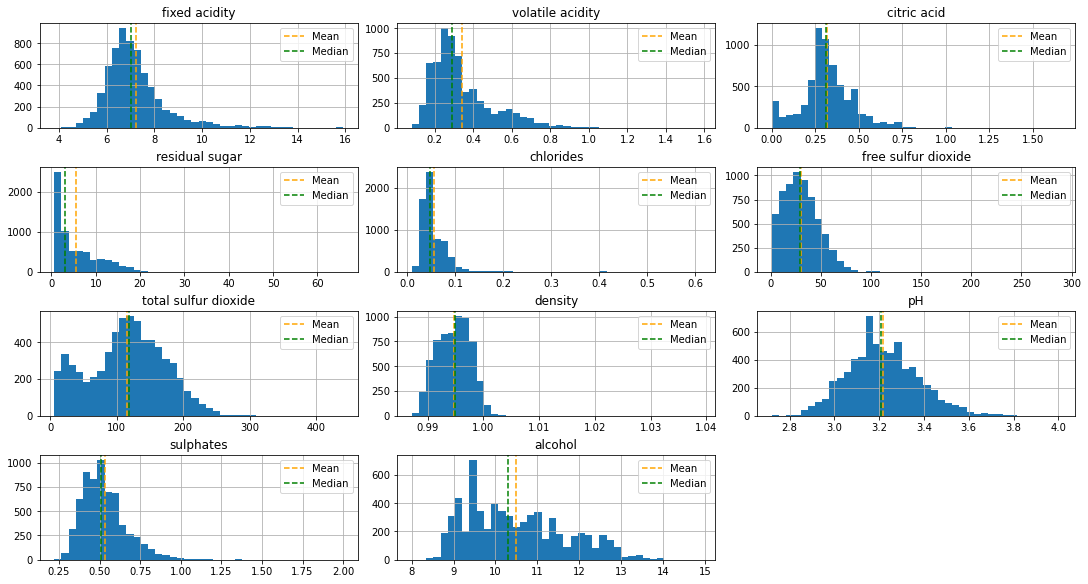

In [19]:
# Numerical variables histograms
draw_histograms(df[numerical_features], df[numerical_features].columns,4,3,40)


The distributions of the explanatory variables "fixed acidity", "sulphates", "citric acid" and "ph" appear to be close to the distribution of a Gaussian. We will try to apply the logarithm function to the "residual sugar and "chlorides" variables (as their distributions are similar to an exponential).

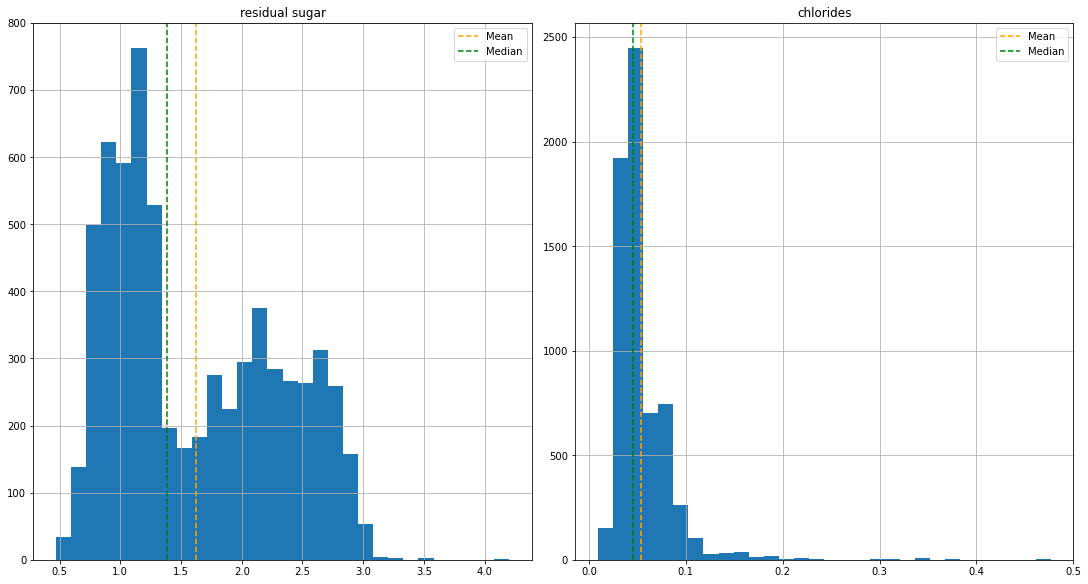

In [20]:
log_volatile_acidity = np.log(df[['chlorides']]+ 1)
log_residual_sugar = np.log(df[['residual sugar']]+ 1)
log = pd.concat([log_residual_sugar, log_volatile_acidity], ignore_index=True)
draw_histograms(log, log, 1, 2, 30)

Not conclusive we'll keep the basic variables. We will try more features engineering in the next part

In [21]:
def draw_boxplots(df, variables, target_col, n_rows, n_cols):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), constrained_layout=True)
    if n_rows * n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(variables):
        if i >= len(axes):
            break
        sns.boxplot(data=df, x=target_col, y=col, ax=axes[i])
        axes[i].set_title(f'{col} vs {target_col}')
        axes[i].set_xlabel(target_col)
        axes[i].set_ylabel(col)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

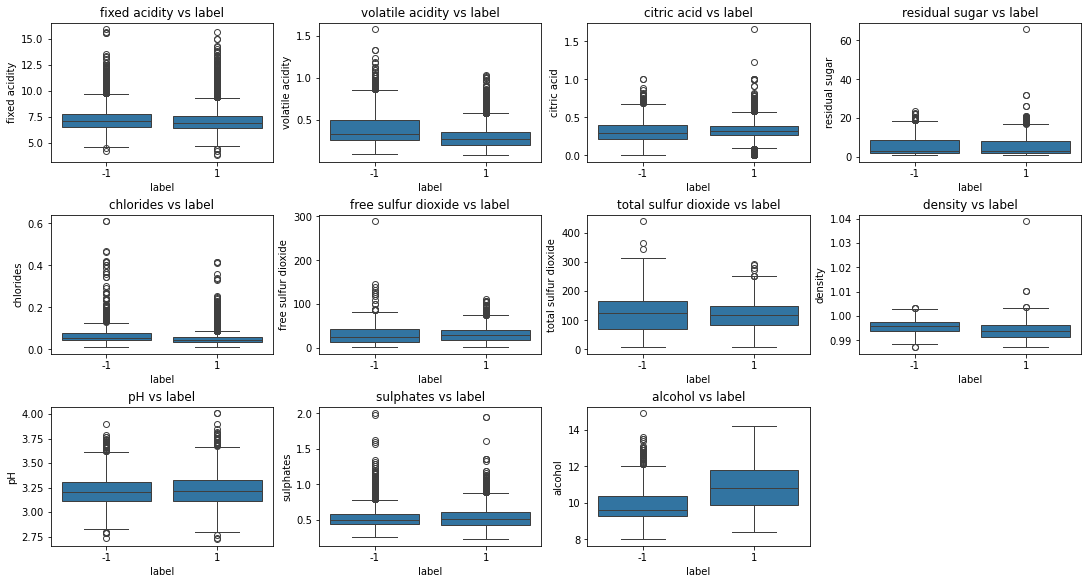

In [22]:
# focus on the label
draw_boxplots(df, numerical_features, target_col='label', n_rows=3, n_cols=4)

The alcohol median is higher for good wines (label=1), confirming the positive correlation between alcohol and quality. But for the other variables, there was nothing of interest.

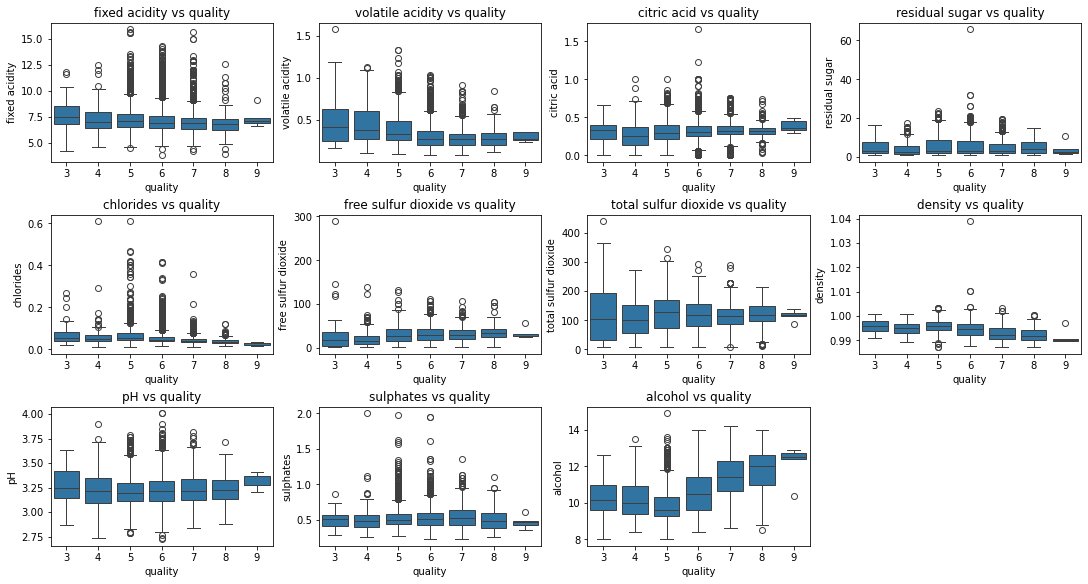

In [23]:
# Focus on the quality score
draw_boxplots(df, numerical_features, target_col='quality', n_rows=3, n_cols=4)

# 1.4.3) Categorical variables

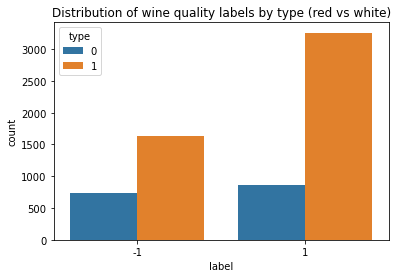

In [24]:
# Plot of wine label distribution by type
sns.countplot(data=df, x="label", hue="type")
plt.title("Distribution of wine quality labels by type (red vs white)")
plt.show()


We can see that most of the white wines (type=1) are considered as good in this data set. And red wines (type=0) are equal distributed between bad and good wines.

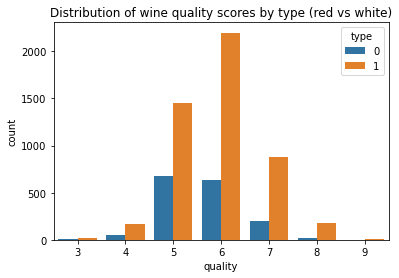

In [25]:
# Focused on the quality score this time 
sns.countplot(data=df, x="quality", hue="type")
plt.title("Distribution of wine quality scores by type (red vs white)")
plt.show()

# 1.5)  Feature Engineering

In this section, we will explore and transform the dataset’s variables to enhance the quality of data used for modeling.

In [26]:
# drop quality columns
df = df.drop(columns='quality')

Based on the observations from the previous box plots, features that show greater differences between classes tend to be more informative for the model. This insight motivates the creation of new features to enhance the model’s ability to distinguish between good and bad wines.

In [27]:
# Ratio of free sulfur dioxide to total sulfur dioxide
df['sulfur_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'])

# Interaction between volatile acidity and pH
df['volatile_acidity_pH'] = df['volatile acidity'] * df['pH']

# Interaction between sulfate and alcohool
df['sulphate_alcohol'] = df['sulphates'] * df['alcohol']

# 5. Sum of fixed acidity, volatile acidity and citric acidity as total acidity
df['total_acidity'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']

# 6. Ratio of density to alcohol
df['density_alcohol_ratio'] = df['density'] / (df['alcohol'])  

new_features = ['sulfur_ratio', 'volatile_acidity_pH', 'sulphate_alcohol', 'total_acidity', 'density_alcohol_ratio' ]

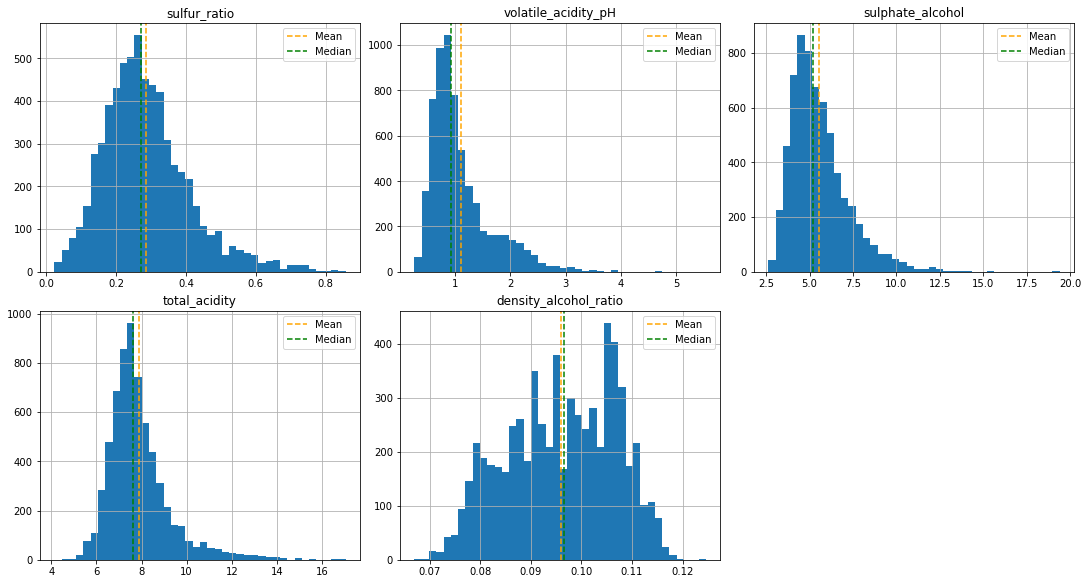

In [28]:
draw_histograms(df[new_features], df[new_features].columns,2,3,40)

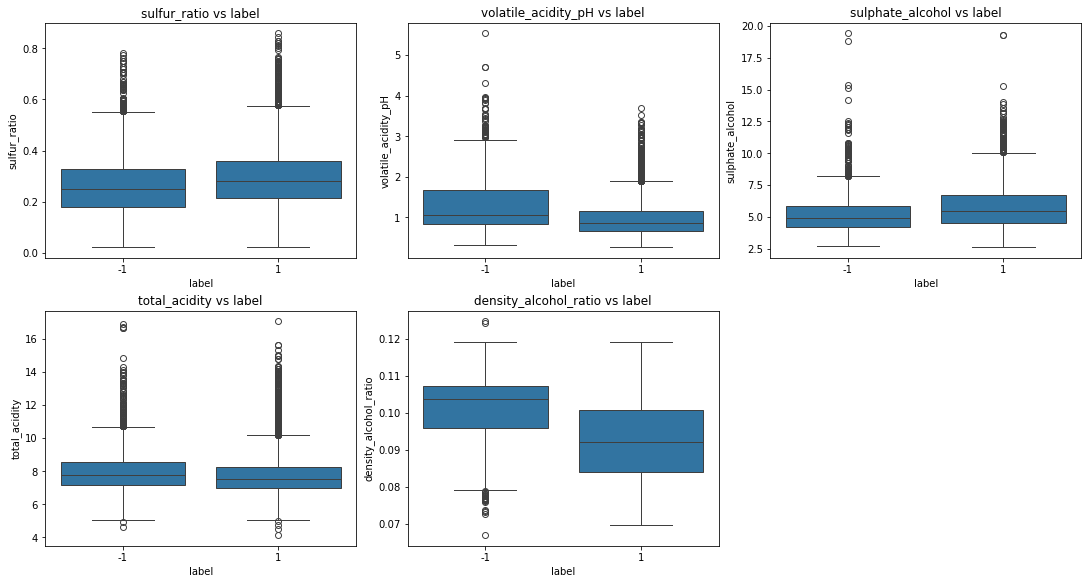

In [29]:
draw_boxplots(df, new_features, 'label', 2, 3)

I will keep **volatile_acidity_pH** and **density_alcohol_ratio** as features because, based on the boxplots, they show differences between the two labels. This suggests that these features have good discriminative power, meaning they can help the model better distinguish between classes. Their distinct distributions across labels indicate that they capture important variations related to wine quality, which should improve the predictive performance of the model.

In [30]:
# Drop the other columns
df.drop(columns=['sulfur_ratio','sulphate_alcohol','total_acidity','sulphate_alcohol'], inplace=True)


In [31]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,label,volatile_acidity_pH,density_alcohol_ratio
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,-1,2.4570,0.106149
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,-1,2.8160,0.101714
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,-1,2.4776,0.101735
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,1,0.8848,0.101837
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,-1,2.4570,0.106149


In [32]:
numerical_features = numerical_features + ['volatile_acidity_pH', 'density_alcohol_ratio']

# 1.6) Data separation and Standardization

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Split data
X = df.drop(columns='label')
y = df['label']

# One-hot encoding for the categorical variable 'type'
#X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [34]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,volatile_acidity_pH,density_alcohol_ratio
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,2.4570,0.106149
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,2.8160,0.101714
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,2.4776,0.101735
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,0.8848,0.101837
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,2.4570,0.106149


label
-1    1933
 1    3264
Name: count, dtype: int64


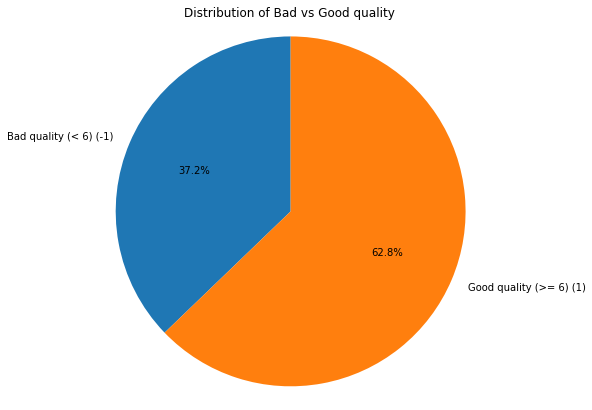

In [35]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation of numerical variables
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

draw_pie(pd.DataFrame({'label': y_train}))

In [36]:
# Convert to NumPy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
print(X_train[:4,:])

[[-0.46822898 -0.59951186  0.20546655  0.4646116  -0.71280142  0.31165933
   0.34356569 -0.29614553 -0.16888369 -1.0832659   0.01376574  1.
  -0.59096628 -0.13471752]
 [ 0.85149992 -0.35284877  1.10406349 -0.70299854  1.06747    -1.4087346
  -1.84751841 -0.20307163  0.26967864  0.59857677  1.60871671  0.
  -0.32397867 -1.49417801]
 [ 0.38571325  2.32961232 -2.14471006 -0.70299854  0.2347624   0.02492701
  -1.29529396 -0.32606213  1.20945505  0.26220824  1.10504798  0.
   2.44266225 -1.1144112 ]
 [-1.55506455  0.20214318  0.06722087 -0.89065017 -0.79894359 -1.00730935
  -0.61837367 -1.49280991  0.958848   -1.01599219  1.0211032   1.
   0.28200339 -1.0750009 ]]


# 2) SVM and LR Implementation

You can see the theoretical part and the code of SVM and logistic regression in the file :

In [37]:
import metrics
import Algo

# 3) Train the two models without kernelizations

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

The purpose of the `manual_grid_search` function is to perform a cross-validated grid search over a predefined set of hyperparameter combinations in order to identify the best model configuration that maximizes validation accuracy.

In [39]:
def manual_grid_search(classifier_class, param_grid, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    import itertools
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    param_combinations = list(itertools.product(*values))
    
    best_score = -np.inf
    best_params = None
    
    for params_tuple in param_combinations:
        params = dict(zip(keys, params_tuple))
        scores = []
        
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = classifier_class(**params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            score = metrics.accuracy(y_val, y_pred)
            scores.append(score)
        mean_score = np.mean(scores)
        #print(f"Params: {params} -> Mean accuracy: {mean_score:.4f}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    
    best_model = classifier_class(**best_params)
    best_model.fit(X, y)
    print(f"Best params: {best_params} with mean accuracy: {best_score:.4f}")
    return best_model, best_params, best_score



In [53]:
def draw_metrics(X_train, X_test, y_train, y_test, classifier):
    y_pred = classifier.predict(X_test)
    y_pred_train = classifier.predict(X_train)
    classifier.plot_metrics()
    classifier.plot_loss()

    #EVALUATE OUR PREDICTION
    print("           train    test ") 
    print("-------------------------") 
    print("f1         %.3f    %.3f" % (metrics.f1_score(y_train, y_pred_train), metrics.f1_score(y_test, y_pred) )) 
    print("accuracy   %.3f    %.3f" % (metrics.accuracy(y_train, y_pred_train), metrics.accuracy(y_test, y_pred) )) 
    print("precision  %.3f    %.3f" % (metrics.precision(y_train, y_pred_train), metrics.precision(y_test, y_pred) )) 
    print("recall     %.3f    %.3f" % (metrics.recall(y_train, y_pred_train), metrics.recall(y_test, y_pred) )) 
    print("")
    
    #print(confusion_matrix(y_test, y_pred))
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,4)) # Sample figsize in inches       
    sns.set_style("whitegrid")
    
    y_test_bin = (y_test == 1).astype(int)
    y_pred_test_bin = (y_pred == 1).astype(int)
    
    sns.heatmap(confusion_matrix(y_test_bin, y_pred_test_bin), annot=True, fmt='d', cmap="Blues", ax=ax1);
    

The `hyperp_search` function performs hyperparameter tuning by using cross-validation to find the best model configuration, then evaluates and visualizes the model’s performance on both the training and test datasets through differents metrics (f1 score, precision, recall and accuracy) and a confusion matrix heatmap.

In [54]:
def hyperp_search(classifier, parameters, X_train, X_test, y_train, y_test):
    best_model, best_params, best_score = manual_grid_search(classifier, parameters, X_train, y_train, cv=5)
    
    print("accuracy_train: %f using %s" % (best_score, best_params))

    draw_metrics(X_train, X_test, y_train, y_test, best_model)
    

### A) SVM

Best params: {'lambda_': 0.05, 'max_iter': 1000, 'size_subset': 20, 'tol': 0.001, 'track': True, 'step_iter': 15} with mean accuracy: 0.7431
accuracy_train: 0.743119 using {'lambda_': 0.05, 'max_iter': 1000, 'size_subset': 20, 'tol': 0.001, 'track': True, 'step_iter': 15}


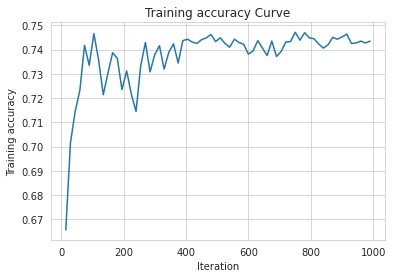

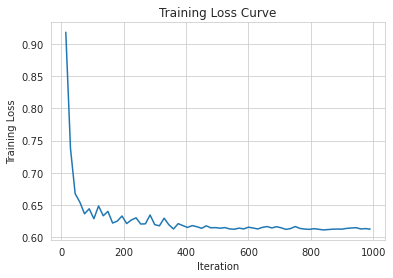

           train    test 
-------------------------
f1         0.801    0.790
accuracy   0.742    0.725
precision  0.777    0.786
recall     0.826    0.794



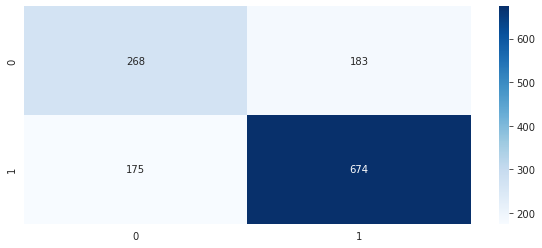

In [81]:
classifier = Algo.SVM
param_SVM ={
    'lambda_' : [0.01,0.05, 0.1, 0.5],
    'max_iter' : [100,300,500,1000],
     'size_subset': [10,20],
    'tol' : [0.1, 0.05,0.001],
    'track': [True],
    'step_iter' : [15]
    
}
hyperp_search(classifier, param_SVM, X_train, X_test, y_train, y_test)

- **Analysis :** 

The best hyperparameters found by the model are {$\lambda$ : $0.05$, 'max_iter': 1000, 'size_subset': 20, 'tol': 0.001, 'track': True, 'step_iter': 15}, yielding a mean accuracy of about 74.3% during cross-validation.

Evaluating the model on the training and test sets shows an F1-score of 0.801 (train) vs. 0.790 (test), and accuracy of 74.2% (train) vs. 72.5% (test). Precision and recall values are also quite close between train and test. So we have a relatively close performance between training and test sets, this suggests that the model is not overfitting and not underfitting.

   - The F1-score being slightly higher than accuracy indicates the model balances well between precision and recall.

   - The precision and recall values close to each other show the model does not have a strong bias towards false positives or false negatives.

However, with accuracy around 72-74%, there is still room for improvement. An analysis of misclassified examples would be beneficial to understand the nature of the errors. Indeed the model distinguishes well between the two classes, especially for good quality wines (label 1), with 674 true positives, but struggles with the classification of bad wine with 183 wines false positives, over a number of total of 183 + 268 = 451 bad wines.

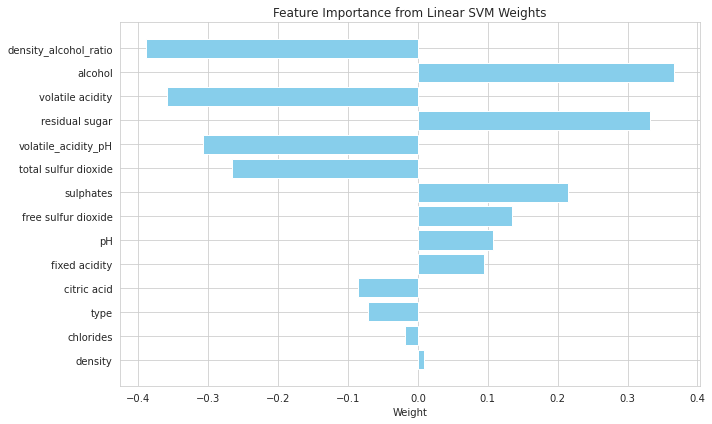

In [69]:
classifier = Algo.SVM(lambda_=0.05, max_iter=1000, size_subset=20,tol=0.001, step_iter=15)
classifier.fit(X_train,y_train)
# Feature names

feature_names = df.drop("label", axis=1).columns

# weights of SVM
weights = classifier.w  

# DataFrame for analysis
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights
})

# Sorted by absolute importance
importance_df['AbsWeight'] = importance_df['Weight'].abs()
importance_df = importance_df.sort_values(by='AbsWeight', ascending=False)

# Affichage graphique
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Weight'], color='skyblue')
plt.title("Feature Importance from Linear SVM Weights")
plt.xlabel("Weight")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation of Feature Importance (Linear SVM)**:

The bar chart above shows the weights learned by the linear SVM model for each feature. These weights represent the direction and strength of each variable’s contribution to the decision boundary:
- **Most influential features:**

- Alcohol and Residual sugar have the highest positive weights, meaning:

- Wines with higher alcohol or residual sugar content are more likely to be classified as good (quality ≥ 6).

- Density_alcohol_ratio, Volatile acidity, and Volatile_acidity_pH have strong negative weights:

- Higher values in these features tend to decrease the likelihood of being a good wine.

- **Moderate contributors:**

Total sulfur dioxide, Sulphates, and Free sulfur dioxide also contribute, though to a lesser extent. These variables may be more subtle indicators of quality, interacting with others.

- **Least impactful:**

- Chlorides, Density, and Type (red/white) show near-zero weights. These features had minimal impact on the decision function in the linear setting.

**Conclusion:** 

The linear SVM is able to capture simple, interpretable relationships between features and wine quality. However, the presence of several small-weight features suggests that some complexity might be lost—which may explain why the kernelized models (like the RBF SVM) perform better on test data as we will see later. Still, this analysis helps identify which chemical components are most predictive of quality, which could be valuable for winemakers or quality control.

### B) Logistic Regression

Best params: {'lambda_': 0.01, 'max_iter': 1000, 'size_subset': 20, 'tol': 0.001, 'track': True, 'step_iter': 15} with mean accuracy: 0.7379
accuracy_train: 0.737922 using {'lambda_': 0.01, 'max_iter': 1000, 'size_subset': 20, 'tol': 0.001, 'track': True, 'step_iter': 15}


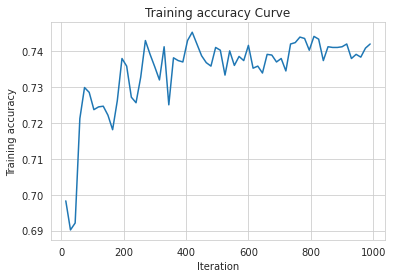

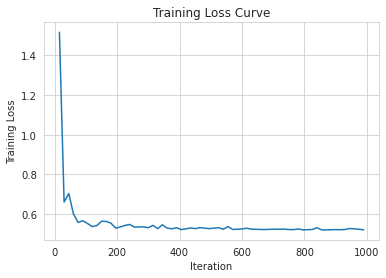

           train    test 
-------------------------
f1         0.806    0.793
accuracy   0.742    0.723
precision  0.762    0.774
recall     0.857    0.814



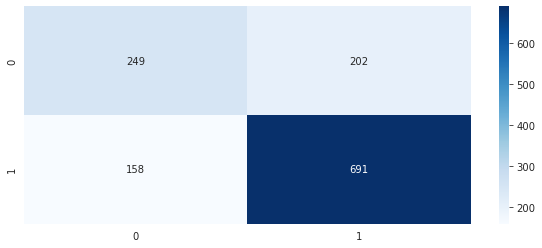

In [79]:
classifier = Algo.LogisticRegression
param_LR ={
    'lambda_' : [0.01,0.05, 0.1, 0.5],
    'max_iter' : [100,300,500,1000],
     'size_subset': [10,20],
    'tol' : [0.1, 0.05,0.001],
    'track': [True],
    'step_iter' : [15]
    
}
hyperp_search(classifier, param_LR, X_train, X_test, y_train, y_test)

- **Analysis :**
-  Generalization and Model Fit :

    The train and test scores are very close, indicating no signs of overfitting.

    The F1 score remains high on both sets (0.806 train, 0.793 test), showing a strong balance between precision and recall.

- Class-wise Performance

    The recall for class 1 (good wine) is high (0.814 on test set), meaning that the model correctly identifies most of the good quality wines.

    The precision for class 1 (0.774) suggests that, among the wines predicted as good, most of them actually are good — a good sign.

    However, the confusion matrix shows some asymmetry:

- False positives (202): wines of bad quality classified as good.

- False negatives (158): wines of good quality classified as bad.

So the model misclassifies more wines of bad quality than good ones, possibly due to the class imbalance (more good wines in the dataset) and/or feature overlap near the threshold (quality = 6).

- Limitations and Room for Improvement

    While the overall accuracy is around 72–74%, which is decent, the error rate remains non-negligible, especially for the minority class (-1).

    Possible directions for improvement:

        Feature engineering: introducing interaction terms or applying dimensionality reduction could help.

        Using class weighting or resampling techniques (like SMOTE) might help address the imbalance.

        Trying non-linear models (e.g., SVM with RBF kernel, Random Forest) may help if the decision boundary is not well captured by logistic regression.
        
So let's try with the kernelization of the algorithms

# 4)  Kernelization

For execution time reasons, I'm not going to use gridSearch with k-fold cross-validation for kernelised versions
### A) Kernelization of the Logistic Regression 

In [50]:
classifier = Algo.LogisticRegression(lambda_=0.01,max_iter= 1000, size_subset=10, tol=0.01, kernel='rbf',rbf_param=3., track=True, step_iter=15)
classifier.fit(X_train,y_train)

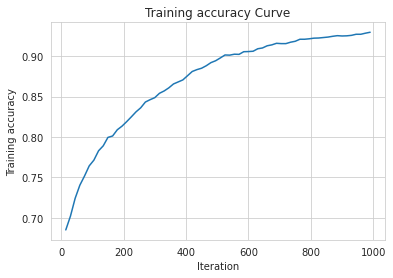

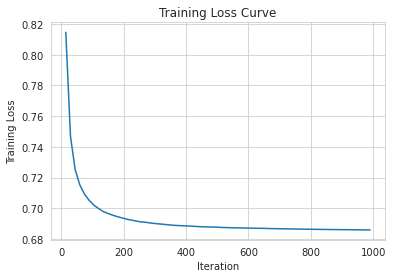

           train    test 
-------------------------
f1         0.945    0.835
accuracy   0.931    0.781
precision  0.935    0.822
recall     0.956    0.848



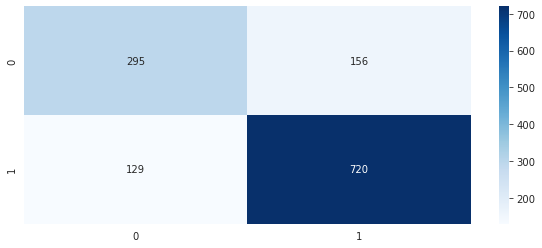

In [55]:
draw_metrics(X_train, X_test, y_train, y_test, classifier)

**Observations:**

- The model shows very strong performance on the training set across all metrics, particularly in recall (0.956), indicating that it captures almost all positive examples during training.

- On the test set, the scores drop—accuracy goes from 93% to 78%, and F1 from 0.945 to 0.835. The drop is consistent across precision and recall. This performance gap suggests moderate overfitting: the model has learned the training data well, but does not generalize as effectively on unseen data.
**Conclusion:**

The kernelized logistic regression model with the RBF kernel is effective but slightly overfits. The gap between training and test performance suggests there is room for improvement, either through regularization, better kernel parameter tuning, or feature refinement. Still, the model demonstrates solid generalization and significantly improved recall and F1-score compared to the classic Logistic Regression.

In [60]:
classifier = Algo.LogisticRegression(lambda_=0.09,max_iter= 1000, size_subset=10, tol=0.01, kernel='rbf',rbf_param=5., track=True, step_iter=15)
classifier.fit(X_train,y_train)

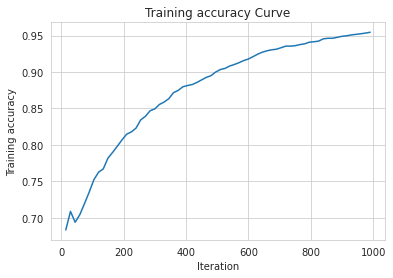

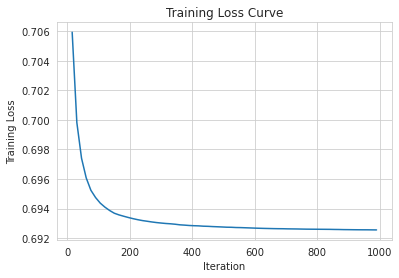

           train    test 
-------------------------
f1         0.964    0.825
accuracy   0.955    0.772
precision  0.960    0.824
recall     0.968    0.827



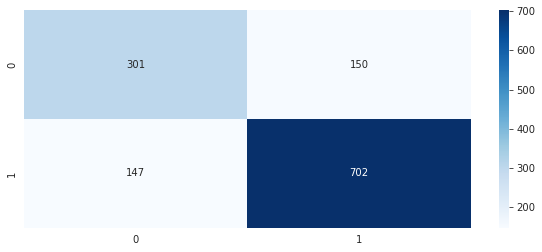

In [61]:
draw_metrics(X_train, X_test, y_train, y_test, classifier)

Slight improvement in detecting bad wines, but slight drop in detecting good wines

In [98]:
classifier = Algo.LogisticRegression(lambda_=0.05,max_iter= 600, size_subset=10, tol=0.001, kernel='poly',degree=5, track=True, step_iter=15)
classifier.fit(X_train,y_train)

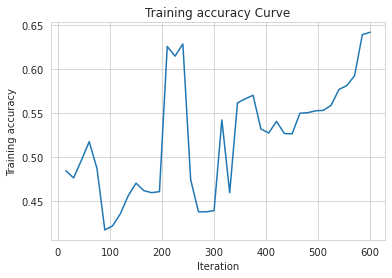

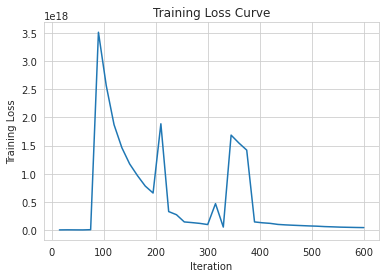

           train    test 
-------------------------
f1         0.698    0.703
accuracy   0.642    0.639
precision  0.742    0.761
recall     0.658    0.653



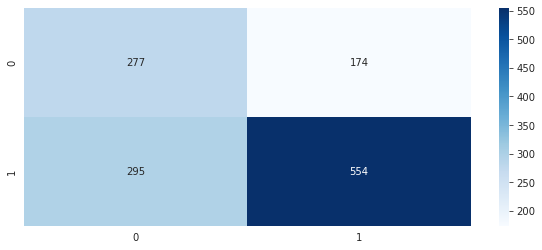

In [99]:
draw_metrics(X_train, X_test, y_train, y_test, classifier)

We can see that the model goes backwards in terms of performance at certain points, this is due to the overflow generated by the polymial kernel, so the values are then sorted and take the value 0, which explains this curve.

### B) Kernelization of the SVM

In [ ]:
draw_metrics(X_train, X_test, y_train, y_test, classifier)

For reasons of execution time and machine performance, I couldn't run a test on the kernelised svm, perhaps because the code wasn't optimised and was too computationally intensive. Perhaps I should have simplified the calculation of the regularisation term by taking only the alpha norm, as I did for logistic regression, and not calculated the RKHS norm regularisation, which is very computationally intensive.

# 5) Conclusion

In this project, we successfully implemented two classical binary classification algorithms from scratch: Logistic Regression (LR) and Support Vector Machine (SVM). Our objective was to predict wine quality, classifying wines as “good” (quality ≥ 6) or “bad” (quality < 6) using the Wine Quality dataset (both red and white wines) from the UCI repository.
Key Achievements : 

- **Data Exploration & Preprocessing:**
    We thoroughly analyzed the dataset, handled label binarization, normalized the features, and split the data into train/test sets. We ensured the pipeline respected good machine learning practices.

- **Model Implementation & Training:**
    We built both LR and SVM models from scratch using vectorized NumPy operations. Our implementations included support for:

 - Stochastic optimization (mini-batch updates)

 - Regularization (lambda_)

  - Kernelization (RBF and polynomial kernels)

- **Hyperparameter Tuning & Validation:**
    We performed manual grid search for hyperparameter tuning and used 5-fold cross-validation to select the best models. This ensured robust and unbiased evaluation.

- **Kernel Methods:**
    By extending both models to their kernelized forms, we observed significantly better performance, particularly with the RBF kernel, which effectively captured non-linear patterns in the data.

Performance Summary
Model	Accuracy (Test)	F1-score (Test)
Logistic Regression (linear)	~72%	~0.79
SVM (linear)	~74%	~0.80
Logistic Regression (RBF)	78%	0.84

The kernelized logistic regression using the RBF kernel achieved the best results overall, with high recall and F1-score on the test set. It outperformed the linear models, demonstrating its ability to generalize better in the presence of non-linear patterns.

**Model Analysis:**

We observed overfitting in some cases (notably with kernelized models), as shown by the gap between training and test performance. However, the gap was moderate and expected given the model capacity. An analysis of misclassified examples could give us a tendency to find the borderline of the samples. Class imbalance could be explored further in future work (e.g., via class weighting or resampling).

**Final Thoughts:**

This project provided hands-on experience with implementing ML algorithms from scratch, kernel methods, and end-to-end model development. It reinforced the importance of:

- Careful data preprocessing

- Rigorous evaluation

- The power of non-linear decision boundaries

- Practical model selection and tuning

With further refinement—such as feature engineering, additional kernel choices, or ensembling—performance could likely be improved further. Nonetheless, the current models already demonstrate good predictive capabilities and provide a solid foundation for binary classification tasks.